In [17]:
import re
import random
import pandas as pd
import hashlib

In [18]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)

age_factor = 1.01
cards_to_age['age'] = cards_to_age['age'] * age_factor

cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Django', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [19]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Network Terms,103.840073,6.922672,14.410681,15
"The Mines of the Behemoth, Shea",734.509344,14.989987,31.835837,49
Exchange Online and Defender,854.869856,21.919740,35.914419,39
Docker,805.072373,25.970077,45.094790,31
SSH + SCP,830.332601,28.632159,49.127710,29
GUI Docker Container,846.852900,40.326329,61.188925,21
Linux,1321.209411,41.287794,62.029761,32
"Everything is Tuberculosis, Green",1006.608269,43.765577,67.939576,23
WinHex,1004.361100,47.826719,66.806713,21
"The Simulacra, Dick",1200.299058,63.173635,84.840180,19


# Histogram

sum of ages: ~60985.07


<Axes: >

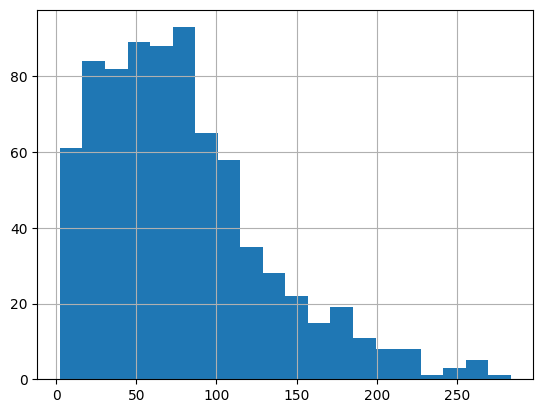

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~60985.07


<Axes: >

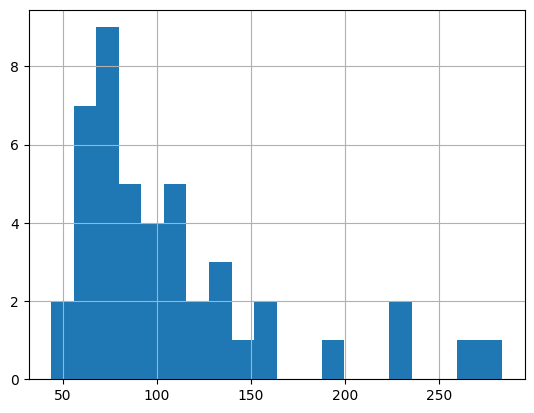

In [21]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [24]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [25]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [26]:
n = random.choice([2, 3, 3, 4, 4, 5])

existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 776
Total card age: 60985.07


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
104,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,283.625925,108.528258,-283.625925,4883.771624,0.439032,45,0,0,-283.625925
105,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,268.699473,108.528258,-283.625925,4883.771624,0.439032,45,1,0,-268.699473
100,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,261.068606,121.132862,-261.068606,4360.783045,0.104983,36,0,0,-261.068606
101,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,260.709972,121.132862,-261.068606,4360.783045,0.104983,36,1,0,-260.709972
92,"Mexican Gothic, Moreno-Garcia",traceries (TRAY-suh-reez)\nnoun\nDelicate orna...,3720f358b6a22134861965f53caa4c3e,256.532382,95.121230,-256.532382,2663.394426,0.893598,28,0,0,-256.532382
93,"Mexican Gothic, Moreno-Garcia",silver salver (SIL-vur SAL-vur)\nnoun\nA flat ...,25010ab30676c7df56f2d417a29190ed,184.621939,95.121230,-256.532382,2663.394426,0.893598,28,1,0,-184.621939
96,Python + Oauth2.0,authorize_url\n\nThe endpoint where the user i...,6a264f45c613880c60d7986e3d683448,256.214982,124.634342,-256.214982,2368.052505,0.593717,19,0,0,-256.214982
97,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,254.435242,124.634342,-256.214982,2368.052505,0.593717,19,1,0,-254.435242
84,Django,ALLOWED_HOSTS\nA Django setting defining which...,98abd3a22fda01e308a7bd38442e8f4c,251.704643,150.669780,-251.704643,5273.442285,0.088660,35,0,0,-251.704643
85,Django,"Static Files\nCSS, JavaScript, and images that...",76729ae376ec4144e681846ea2579ff9,222.798222,150.669780,-251.704643,5273.442285,0.088660,35,1,0,-222.798222


## Card Count

In [27]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [28]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [29]:
existing_cards.head(10)['age'].sum()

np.float64(2500.4113848424695)

In [30]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
104,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,283.625925,108.528258,-283.625925,4883.771624,0.439032,45,0,0,-283.625925
105,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,268.699473,108.528258,-283.625925,4883.771624,0.439032,45,1,0,-268.699473
100,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,261.068606,121.132862,-261.068606,4360.783045,0.104983,36,0,0,-261.068606
101,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,260.709972,121.132862,-261.068606,4360.783045,0.104983,36,1,0,-260.709972
92,"Mexican Gothic, Moreno-Garcia",traceries (TRAY-suh-reez)\nnoun\nDelicate orna...,3720f358b6a22134861965f53caa4c3e,256.532382,95.121230,-256.532382,2663.394426,0.893598,28,0,0,-256.532382
96,Python + Oauth2.0,authorize_url\n\nThe endpoint where the user i...,6a264f45c613880c60d7986e3d683448,256.214982,124.634342,-256.214982,2368.052505,0.593717,19,0,0,-256.214982
97,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,254.435242,124.634342,-256.214982,2368.052505,0.593717,19,1,0,-254.435242
84,Django,ALLOWED_HOSTS\nA Django setting defining which...,98abd3a22fda01e308a7bd38442e8f4c,251.704643,150.669780,-251.704643,5273.442285,0.088660,35,0,0,-251.704643
88,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,243.150653,114.165153,-243.150653,1940.807596,0.114565,17,0,0,-243.150653
98,Python + Oauth2.0,handler.end_headers()\n\nFinalizes the HTTP re...,91ad05cd6046d3375013aa16d642650d,238.072007,124.634342,-256.214982,2368.052505,0.593717,19,2,1,-238.072007


In [31]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 78.589'